In [1]:
import tensorflow as tf
import numpy as np
import math
import os
import random
import numpy as np
import pandas as pd
from pandas import DataFrame
import cPickle as pickle
import math
import copy

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
with open('../data/state_features.txt') as f:
    state_features = f.read().split()
print (state_features)
print len(state_features)

['Albumin', 'Arterial_BE', 'Arterial_lactate', 'Arterial_pH', 'BUN', 'CO2_mEqL', 'Calcium', 'Chloride', 'Creatinine', 'DiaBP', 'FiO2_1', 'GCS', 'Glucose', 'HCO3', 'HR', 'Hb', 'INR', 'Ionised_Ca', 'Magnesium', 'MeanBP', 'PT', 'PTT', 'PaO2_FiO2', 'Platelets_count', 'Potassium', 'RR', 'SGOT', 'SGPT', 'SIRS', 'SOFA', 'Shock_Index', 'Sodium', 'SpO2', 'SysBP', 'Temp_C', 'Total_bili', 'WBC_count', 'Weight_kg', 'age', 'elixhauser', 'gender', 'mechvent', 'output_4hourly', 'output_total', 'paCO2', 'paO2', 're_admission']
47


In [4]:
df = pd.read_csv('../data/rl_train_data_final_cont.csv')

In [6]:
df.head()

,Unnamed: 0.1.1,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,mortality_90d,...,median_dose_vaso,max_dose_vaso,input_total_tev,input_4hourly_tev,output_total,output_4hourly,cumulated_balance_tev,vaso_input,iv_input,reward
0,0,1,3,7245052800,0.0,0.412568,0.0,0.0,0,1,...,0.0,0.0,0.797351,0.939195,0.589916,0.750908,0.554500,0.0,4.0,0
1,1,2,3,7245067200,0.0,0.412568,0.0,0.0,0,1,...,0.0,0.0,0.831780,0.934543,0.674384,0.819589,0.580033,0.0,4.0,0
2,2,3,3,7245081600,0.0,0.412568,0.0,0.0,0,1,...,0.0,0.0,0.833222,0.656575,0.765423,0.939329,0.555033,0.0,2.0,0
3,3,4,3,7245096000,0.0,0.412568,0.0,0.0,0,1,...,0.0,0.0,0.834033,0.603831,0.783597,0.847073,0.545700,0.0,2.0,0
4,4,5,3,7245110400,0.0,0.412568,0.0,0.0,0,1,...,0.0,0.0,0.834836,0.603831,0.794059,0.811583,0.539533,0.0,2.0,0


In [ ]:
val_df = pd.read_csv('../data/rl_val_data_final_cont.csv')

In [ ]:
test_df = pd.read_csv('../data/rl_test_data_final_cont.csv')

In [7]:
REWARD_THRESHOLD = 15
reg_lambda = 5

In [8]:
# PER important weights and params
per_flag = True
beta_start = 0.9
df['prob'] = abs(df['reward'])
temp = 1.0/df['prob']
#temp[temp == float('Inf')] = 1.0
df['imp_weight'] = pow((1.0/len(df) * temp), beta_start)

In [11]:
hidden_1_size = 128
hidden_2_size = 128
#  Q-network uses Leaky ReLU activation
class Qnetwork():
    def __init__(self):
        self.phase = tf.placeholder(tf.bool)

        self.num_actions = 25

        self.input_size = len(state_features)

        self.state = tf.placeholder(tf.float32, shape=[None, self.input_size],name="input_state")

        self.fc_1 = tf.contrib.layers.fully_connected(self.state, hidden_1_size, activation_fn=None)
        self.fc_1_bn = tf.contrib.layers.batch_norm(self.fc_1, center=True, scale=True, is_training=self.phase)
        self.fc_1_ac = tf.maximum(self.fc_1_bn, self.fc_1_bn*0.5)
        self.fc_2 = tf.contrib.layers.fully_connected(self.fc_1_ac, hidden_2_size, activation_fn=None)
        self.fc_2_bn = tf.contrib.layers.batch_norm(self.fc_2, center=True, scale=True, is_training=self.phase)
        self.fc_2_ac = tf.maximum(self.fc_2_bn, self.fc_2_bn*0.5)
        
        # advantage and value streams
        self.streamA,self.streamV = tf.split(self.fc_2_ac,2,axis=1)
        self.AW = tf.Variable(tf.random_normal([hidden_2_size//2,self.num_actions]))
        self.VW = tf.Variable(tf.random_normal([hidden_2_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Then combine them together to get our final Q-values.
        self.q_output = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
       
        self.predict = tf.argmax(self.q_output,1, name='predict') # vector of length batch size
        
        #Below we obtain the loss by taking the sum of squares difference between the target and predicted Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,self.num_actions,dtype=tf.float32)
        
        # Importance sampling weights for PER, used in network update         
        self.imp_weights = tf.placeholder(shape=[None], dtype=tf.float32)
        
        # select the Q values for the actions that would be selected         
        self.Q = tf.reduce_sum(tf.multiply(self.q_output, self.actions_onehot), reduction_indices=1) # batch size x 1 vector
        
        
        # regularisation penalises the network when it produces rewards that are above the
        # reward threshold, to ensure reasonable Q-value predictions      
        self.reg_vector = tf.maximum(tf.abs(self.Q)-REWARD_THRESHOLD,0)
        self.reg_term = tf.reduce_sum(self.reg_vector)
        
        self.abs_error = tf.abs(self.targetQ - self.Q)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        
        # below is the loss when we are not using PER
        self.old_loss = tf.reduce_mean(self.td_error)
        
        # as in the paper, to get PER loss we weight the squared error by the importance weights
        self.per_error = tf.multiply(self.td_error, self.imp_weights)

        # total loss is a sum of PER loss and the regularisation term
        if per_flag:
            self.loss = tf.reduce_mean(self.per_error) + reg_lambda*self.reg_term
        else:
            self.loss = self.old_loss + reg_lambda*self.reg_term

        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(self.update_ops):
        # Ensures that we execute the update_ops before performing the model update, so batchnorm works
            self.update_model = self.trainer.minimize(self.loss)

In [12]:
# function is needed to update parameters between main and target network
# tf_vars are the trainable variables to update, and tau is the rate at which to update
# returns tf ops corresponding to the updates
def update_target_graph(tf_vars,tau):
    total_vars = len(tf_vars)
    op_holder = []
    for idx,var in enumerate(tf_vars[0:int(total_vars/2)]):
        op_holder.append(tf_vars[idx+int(total_vars/2)].assign((var.value()*tau) + ((1-tau)*tf_vars[idx+int(total_vars/2)].value())))
    return op_holder

In [13]:
def update_target(op_holder,sess):
    for op in op_holder:
        sess.run(op)

In [14]:
# define an action mapping - how to get an id representing the action from the (iv,vaso) tuple
action_map = {}
count = 0
for iv in range(5):
    for vaso in range(5):
        action_map[(iv,vaso)] = count
        count += 1

In [16]:
# generates batches for the Q network - depending on train and eval_type, can select data from train/val/test sets.
def process_batch(size, train=True, eval_type = None):
    if not train:
        if eval_type is None:
            raise Exception('Provide eval_type to process_batch')
        elif eval_type == 'train':
            a = df.copy()
        elif eval_type == 'val':
            a = val_df.copy()
        elif eval_type == 'test':
            a = test_df.copy()
        else:
            raise Exception('Unknown eval_type')
    else:
        if per_flag:
            # uses prioritised exp replay
            a = df.sample(n=size, weights=df['prob'])
        else:
            a = df.sample(n=size)
    states = None
    actions = None
    rewards = None
    next_states = None
    done_flags = None
    for i in a.index:
        cur_state = a.ix[i,state_features]
        iv = int(a.ix[i, 'iv_input'])
        vaso = int(a.ix[i, 'vaso_input'])
        action = action_map[iv,vaso]
        reward = a.ix[i,'reward']

        if i != df.index[-1]:
            # if not terminal step in trajectory             
            if df.ix[i, 'icustayid'] == df.ix[i+1, 'icustayid']:
                next_state = df.ix[i + 1, state_features]
                done = 0
            else:
                # trajectory is finished
                next_state = np.zeros(len(cur_state))
                done = 1
        else:
            # last entry in df is the final state of that trajectory
            next_state = np.zeros(len(cur_state))
            done = 1

        if states is None:
            states = copy.deepcopy(cur_state)
        else:
            states = np.vstack((states,cur_state))

        if actions is None:
            actions = [action]
        else:
            actions = np.vstack((actions,action))

        if rewards is None:
            rewards = [reward]
        else:
            rewards = np.vstack((rewards,reward))

        if next_states is None:
            next_states = copy.deepcopy(next_state)
        else:
            next_states = np.vstack((next_states,next_state))

        if done_flags is None:
            done_flags = [done]
        else:
            done_flags = np.vstack((done_flags,done))
    
    return (states, np.squeeze(actions), np.squeeze(rewards), next_states, np.squeeze(done_flags), a)


In [18]:
#  Used to run diagnostics on the train set
phys_q_train = []
agent_q_train = []
phys_actions_tr = []
agent_actions_tr = []
def train_set_performance():
    count = 0
    global phys_q_train
    global agent_q_train
    global phys_actions
    global agent_actions
    phys_q_train = []
    agent_q_train = []
    phys_actions_tr = []
    agent_actions_tr = []
    for r in df.index:
        cur_state = [df.ix[r,state_features]]
        iv = int(df.ix[r, 'iv_input'])
        vaso = int(df.ix[r, 'vaso_input'])
        action = action_map[iv,vaso]
        output_q = np.squeeze(sess.run(mainQN.q_output, feed_dict = {mainQN.state : cur_state, mainQN.phase : False}))
        phys_q_train.append(output_q[action])
        agent_q_train.append(max(output_q))
        agent_actions_tr.append(np.argmax(output_q))
        phys_actions_tr.append(action)
        count += 1

In [ ]:
def do_eval(eval_type)
    states,actions,rewards,next_states, done_flags, _ = process_batch(size=None,train=False,eval_type=eval_type)

    # firstly get the chosen actions at the next timestep
    actions_from_q1 = sess.run(mainQN.predict,feed_dict={mainQN.state:next_states, mainQN.phase : 0})

    # Q values for the next timestep from target network, as part of the Double DQN update
    Q2 = sess.run(targetQN.q_output,feed_dict={targetQN.state:next_states, targetQN.phase : 0})

    # handles the case when a trajectory is finished
    end_multiplier = 1 - done_flags

    # target Q value using Q values from target, and actions from main
    double_q_value = Q2[range(batch_size),actions_from_q1]

    # definition of target Q
    targetQ = rewards + (gamma*double_q_value * end_multiplier)

    # get the output q's, actions, and loss
    q_output,actions_taken, loss = sess.run([mainQN.q_output,mainQN.predict, mainQN.abs_error], \
        feed_dict={mainQN.state:states,
                   mainQN.targetQ:targetQ, 
                   mainQN.actions:actions,
                   mainQN.phase:False})
    
    # return the relevant q values and actions
    phys_q = q_output[range(len(q_output)), actions]
    agent_q = q_output[range(len(q_output)), actions_taken]
    error = np.mean(abs_error)
    return phys_q, actions, agent_q, actions_taken, error

In [23]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # Don't use all GPUs 
config.allow_soft_placement = True  # Enable manual control

In [109]:
# The main training loop is here
per_alpha = 0.6 # PER hyperparameter
per_epsilon = 0.01 # PER hyperparameter
batch_size = 30
gamma = 1 # discount factor 
num_steps = 200000 # How many steps to train for
load_model = True #Whether to load a saved model.
save_dir = "./dqn_normal/'
save_path = "./dqn_normal/ckpt"#The path to save our model to.
tau = 0.001 #Rate to update target network toward primary network
tf.reset_default_graph()
mainQN = Qnetwork()
targetQN = Qnetwork()
av_q_list = []

saver = tf.train.Saver(tf.global_variables())

init = tf.global_variables_initializer()

trainables = tf.trainable_variables()

target_ops = update_target_graph(trainables,tau)

#Make a path for our model to be saved in.
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

with tf.Session(config=config) as sess:
    if load_model == True:
        print('Trying to load model...')
        try:
            restorer = tf.train.import_meta_graph(save_path + '.meta')
            restorer.restore(sess, tf.train.latest_checkpoint(save_dir))
            print "Model restored"
        except IOError:
            print "No previous model found, running default init"
            sess.run(init)
        try:
            per_weights = pickle.load(open( save_dir + "per_weights.p", "rb" ))
            imp_weights = pickle.load(open( save_dir + "imp_weights.p", "rb" ))
            
            # the PER weights, governing probability of sampling, and importance sampling
            # weights for use in the gradient descent updates
            df['prob'] = per_weights
            df['imp_weight'] = imp_weights
            print "PER and Importance weights restored"
        except IOError:
            print("No PER weights found - default being used for PER and importance sampling")
    else:
        print("Running default init")
        sess.run(init)
    print("Init done")
    for i in range(num_steps):
        net_loss = 0.0
        net_q = 0.0
        states,actions,rewards,next_states, done_flags, sampled_df = process_batch(batch_size)
        
        # firstly get the chosen actions at the next timestep
        actions_from_q1 = sess.run(mainQN.predict,feed_dict={mainQN.state:next_states, mainQN.phase : 1})
        
        # actions chosen now, as a check
        cur_act = sess.run(mainQN.predict,feed_dict={mainQN.state:states, mainQN.phase : 1})

        # Q values for the next timestep from target network, as part of the Double DQN update
        Q2 = sess.run(targetQN.q_output,feed_dict={targetQN.state:next_states, targetQN.phase : 1})

        # handles the case when a trajectory is finished
        end_multiplier = 1 - done_flags
    
        # target Q value using Q values from target, and actions from main
        double_q_value = Q2[range(batch_size),actions_from_q1]
        
        # empirical hack to make the Q values never exceed the threshold - helps learning
        double_q_value[double_q_value > REWARD_THRESHOLD] = REWARD_THRESHOLD
        double_q_value[double_q_value < -REWARD_THRESHOLD] = -REWARD_THRESHOLD
        
        # definition of target Q
        targetQ = rewards + (gamma*double_q_value * end_multiplier)

        # Calculate the importance sampling weights for PER
        imp_sampling_weights = np.array(sampled_df['imp_weight'] / float(max(df['imp_weight'])))
        imp_sampling_weights[np.isnan(imp_sampling_weights)] = 1
        imp_sampling_weights[imp_sampling_weights <= 0.001] = 0.001

        # Train with the batch
        _,loss, error = sess.run([mainQN.update_model,mainQN.loss, mainQN.abs_error], \
            feed_dict={mainQN.state:states,
                       mainQN.targetQ:targetQ, 
                       mainQN.actions:actions,
                       mainQN.phase:True,
                       mainQN.imp_weights:imp_sampling_weights})

        # Update target towards main network
        update_target(target_ops,sess)
        
        net_loss += sum(error)
        net_q += np.mean(targetQ)
        
        # Set the selection weight/prob to the abs prediction error and update the importance sampling weight
        new_weights = pow((error + per_epsilon), per_alpha)
        df.ix[df.index.isin(sampled_df.index), 'prob'] = new_weights
        temp = 1.0/new_weights
        df.ix[df.index.isin(sampled_df.index), 'imp_weight'] = pow(((1.0/len(df)) * temp), beta_start)
        
        if i % 1000 == 0 and i > 0:
            saver.save(sess,save_path)
            print("Saved Model, step is " + str(i))
            
            av_loss = net_loss/1000.0
            print("Average loss is ", av_loss)
            net_loss = 0.0
                        
            print ("Saving PER and importance weights")
            with open(save_dir + 'per_weights.p', 'wb') as f:
                pickle.dump(df['prob'], f)
            with open(save_dir + 'imp_weights.p', 'wb') as f:
                pickle.dump(df['imp_weight'], f)
        
        if (i % 1000==0) and i > 0:
            print "physactions ", actions
            print " chosen actions ", cur_act
            if i >= 1000:
                # run an evaluation on the validation set
                phys_q, phys_actions, agent_q, agent_actions, mean_abs_error = do_eval(eval_type = 'val')        
                print mean_abs_error
                print np.mean(phys_q)
                print np.mean(agent_q)
                break
#     saver.save(sess,save_path)

Trying to load model...
Model restored
PER and Importance weights restored
Init done
Saved Model, step is 1000
('Average loss is ', 0.29190072822570801)
Saving PER and importance weights
physactions  [10 10  0 20  0  5  0 10 15 15  0  0 20  5  0  0 14 15 10  0 24  0  5  5  0
 10  5  0  5 18]
 chosen actions  [ 2 15 23  9  9  5 19  2 16 15  5  0 23  0  7 21  2 14 14  0 21 20 18  1 23
  0  8 24  0 10]
0.0
5.82176
9.60063


In [110]:
pd.Series(agent_actions).value_counts()

2     8528
0     6446
8     5716
16    3947
15    3362
10    3040
20    3034
23    2598
5     2555
18    2180
21    1900
12    1205
13    1111
1      505
14     445
9      414
22     358
7      323
11     278
17     210
3      177
24     152
6      145
4       95
19      72
dtype: int64

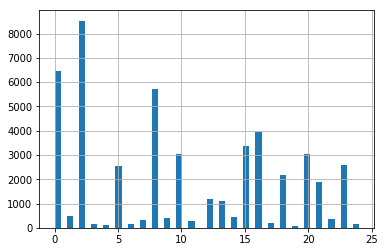

In [111]:
% matplotlib inline
pd.Series(agent_actions).hist(bins=50)

In [ ]:
# get the chosen actions for the train, val, and test set when training is complete.
_, _, agent_q_train, agent_actions_train, _ = do_eval(eval_type = 'train')        
_, _, agent_q_val, agent_actions_val, _ = do_eval(eval_type = 'val')        
_, _, agent_q_test, agent_actions_test, _ = do_eval(eval_type = 'test')        

In [ ]:
# save everything for later - they're used in policy evaluation and when generating plots
with open(save_dir + 'dqn_normal_actions_train.p', 'wb') as f:
    pickle.dump(agent_actions_train, f)
with open(save_dir + 'dqn_normal_actions_val.p', 'wb') as f:
    pickle.dump(agent_actions_val, f)
with open(save_dir + 'dqn_normal_actions_test.p', 'wb') as f:
    pickle.dump(agent_actions_test, f)

In [ ]:
with open(save_dir + 'dqn_normal_q_train.p', 'wb') as f:
    pickle.dump(agent_q_train, f)
with open(save_dir + 'dqn_normal_q_val.p', 'wb') as f:
    pickle.dump(agent_q_val, f)
with open(save_dir + 'dqn_normal_q_test.p', 'wb') as f:
    pickle.dump(agent_q_test, f)